In [1]:
import numpy as np
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from PIL import Image
from io import BytesIO
from trajectory_visualizer import TrajectoryVisualizer
from StrokeTrajDataset import StrokeTrajDataset
from TrajDataset import TrajDataset
from TrajVAE import TrajVAE
from TrajToStroke import TrajToStroke
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
import wandb
from sklearn.manifold import TSNE
import plotly.express as px
from CombinedModel import CombinedModel

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

tv = TrajectoryVisualizer(-1, 1, -1, 1, 0, 1)

In [2]:
with open("simulated_stroke_data/trajectories.npy", "rb") as f:
    trajectories = np.load(f)
trajectories = torch.from_numpy(trajectories).float()

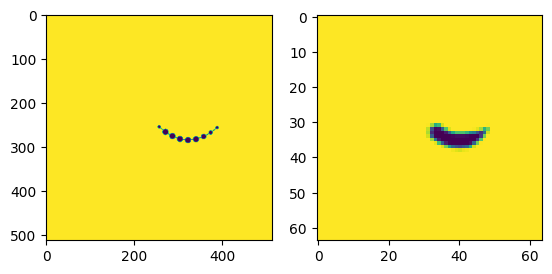

In [3]:
idx = 2
_, axs = plt.subplots(1,2)
axs[0].imshow(tv.visualize_trajectory(trajectories[idx]))
axs[1].imshow(tv.render_trajectory(trajectories[idx]))

In [5]:
wandb.init(project="diverse-strokes-split", mode="online")

max_capacity = 0
beta = 0.0003
num_epochs = 600
epochs_per_save = 50
schedule = "constant"
duration = 100

wandb.config = {
    "epochs": num_epochs,
    "beta": beta,
    "max_capacity": max_capacity,
    "schedule": schedule,
    "duration": duration
}

def get_beta(step):
    # if schedule="constant", always return beta
    # if schedule="monotonic", increase linearly to beta until duration, at which it stays constant
    # if schedule="cyclical", increase from 0 to beta over duration steps, stay constant for duration more steps, and repeat
    if schedule == "constant":
        return beta
    elif schedule == "monotonic":
        return min(beta * step/duration, beta)
    elif schedule == "cyclical":
        step = step % (2*duration)
        return min(beta * step/duration, beta)
    else:
        raise ValueError("invalid schedule")

model = TrajVAE()
model.to(device)
optimizer = optim.Adam(model.parameters())

train_test_split = int(0.8 * len(trajectories))
from sklearn.utils import shuffle
t = shuffle(trajectories, random_state=0)
train = t[:train_test_split]
test = t[train_test_split:]

train_dataset = TrajDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = TrajDataset(test)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

def plot_embeddings(model, data):
    # data: [[class, trajectories], [class, trajectories], ...] where each subarray is a different class
    encodings = []
    classes = []
    for (c, trajectories) in data:
        dataset = TrajDataset(trajectories)
        dataloader = DataLoader(dataset, batch_size=16, shuffle=False)
        classes += [c for _ in range(len(dataset))]
        for trajectory in dataloader:
            trajectory = trajectory.to(device)
            mean, _ = model.encode(trajectory)
            encodings.append(mean)
    encodings = torch.concat(encodings, axis=0) # n x 5
    encodings = encodings.cpu().detach()
    reduced_encodings = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(encodings)
    fig = px.scatter(x=reduced_encodings[:,0], y=reduced_encodings[:,1], color=classes)
    return fig

def validation(model, dataloader):
    model.eval()
    total_loss = 0
    originals = []
    decoder_outputs = []
    
    for trajectory in dataloader:
        batch_size = len(trajectory)
        trajectory = trajectory.to(device)
        args = model(trajectory)
        loss = model.reconstruction_loss(args)
        total_loss += loss * batch_size
        
        for i in range(batch_size):
            traj_dec = args[0][i].cpu().detach()
            traj = args[1][i].cpu().detach()
            decoder_outputs.append(traj_dec)
            originals.append(traj)

    avg_loss = total_loss / len(dataloader.dataset)
    model.train()
    return avg_loss, decoder_outputs, originals

fig = plot_embeddings(
    model,
    [
        ["bezier", trajectories[:200]],
        ["circle", trajectories[200:]]
    ]
)
wandb.log({"embeddings": fig})

for epoch in range(num_epochs):
    cur_beta = get_beta(epoch)
    capacity = epoch / num_epochs * max_capacity
    total_loss = 0
    for (i, trajectory) in enumerate(train_dataloader):
        batch_size = len(trajectory)
        trajectory = trajectory.to(device)
        args = model(trajectory)
        loss = model.loss(args, cur_beta, capacity)
        
        total_loss += loss * batch_size
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i == 0 and epoch%epochs_per_save == epochs_per_save-1:
            output_dir = f"training_outputs/epoch{epoch}/train"
            os.makedirs(output_dir, exist_ok=True)
            for i in range(batch_size):
                traj_dec = args[0][i].cpu().detach()
                traj_dec_img = tv.visualize_trajectory(traj_dec).float()
                traj = args[1][i].cpu().detach()
                traj_img =  tv.visualize_trajectory(traj).float()

                images = [
                    wandb.Image(traj_dec_img, caption='decoded trajectory'),
                    wandb.Image(traj_img, caption='original trajectory')
                ]
                wandb.log({"training outputs": images})
                plt.imsave(f"{output_dir}/{i}-traj_decoded.png", traj_dec_img)
                plt.imsave(f"{output_dir}/{i}-traj_original.png", traj_img)
    
    train_loss = total_loss / len(train_dataset)
    val_loss, decoded_list, original_list = validation(model, val_dataloader)
    wandb.log({
        'epoch': epoch,
        'capacity': capacity,
        'cur_beta': cur_beta,
        'train_loss': train_loss,
        'val_loss': val_loss
    })

    if epoch%epochs_per_save == epochs_per_save-1:
        output_dir = f"training_outputs/epoch{epoch}/val"
        os.makedirs(output_dir, exist_ok=True)
        for i in range(len(decoded_list)):
            traj_dec = decoded_list[i]
            traj = original_list[i]
            traj_dec_img = tv.visualize_trajectory(traj_dec).float()
            traj_img =  tv.visualize_trajectory(traj).float()

            images = [
                wandb.Image(traj_dec_img, caption='decoded trajectory'),
                wandb.Image(traj_img, caption='original trajectory')
            ]
            wandb.log({"validation outputs": images})
            plt.imsave(f"{output_dir}/{i}-traj_decoded.png", tv.visualize_trajectory(traj_dec))
            plt.imsave(f"{output_dir}/{i}-traj_original.png", tv.visualize_trajectory(traj))
        fig = plot_embeddings(
            model,
            [
                ["bezier", trajectories[:200]],
                ["circle", trajectories[200:]]
            ]
        )
        wandb.log({"embeddings": fig})
    
    print(f"Epoch {epoch}: Train loss={train_loss}, Validation loss={val_loss}")

torch.save(model.state_dict(), "traj_vae.pt")

capacity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cur_beta,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
capacity,0.0
cur_beta,0.001
epoch,599
train_loss,0.00314
val_loss,0.00122


Epoch 0: Train loss=0.050758421421051025, Validation loss=0.02220587618649006
Epoch 1: Train loss=0.01627880334854126, Validation loss=0.014172837138175964
Epoch 2: Train loss=0.01159693207591772, Validation loss=0.010765484534204006
Epoch 3: Train loss=0.010398104786872864, Validation loss=0.010822533629834652
Epoch 4: Train loss=0.009299997240304947, Validation loss=0.009603451006114483
Epoch 5: Train loss=0.008735306560993195, Validation loss=0.008865478448569775
Epoch 6: Train loss=0.007621109019964933, Validation loss=0.006641131825745106
Epoch 7: Train loss=0.006305725779384375, Validation loss=0.005317417439073324
Epoch 8: Train loss=0.005018368363380432, Validation loss=0.004073261748999357
Epoch 9: Train loss=0.004602285102009773, Validation loss=0.0037078247405588627
Epoch 10: Train loss=0.004447086248546839, Validation loss=0.003785592271015048
Epoch 11: Train loss=0.004231176804751158, Validation loss=0.0035646387841552496
Epoch 12: Train loss=0.0041395085863769054, Validat

In [4]:
%%capture
model = TrajVAE()
model.load_state_dict(torch.load("traj_vae.pt"))
model.to(device)

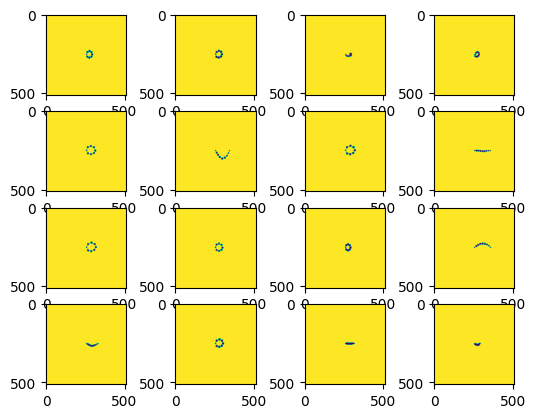

In [5]:
_, t = model.sample_latent(16)
_, axs = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        axs[i][j].imshow(tv.visualize_trajectory(t[4*i+j].cpu().detach()))

In [38]:
def no_gap_plot(data): # https://stackoverflow.com/questions/42675864/how-to-remove-gaps-between-image-subplots
    # data: N x M x individual image
    N = len(data)
    M = len(data[0])
    heights = [50 for a in data]
    widths = [50 for a in data[0]]
    
    fig_width = 8.  # inches
    fig_height = fig_width * sum(heights) / sum(widths)

    f, axarr = plt.subplots(N,M, figsize=(fig_width, fig_height), gridspec_kw={'height_ratios':heights})

    for i in range(N):
        for j in range(M):
            if M == 1: # Hack because matplotlib doesn't allow last dimension 1
                axarr[i].imshow(data[i][j])
                axarr[i].axis('off')
            else:
                axarr[i][j].imshow(data[i][j])
                axarr[i][j].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

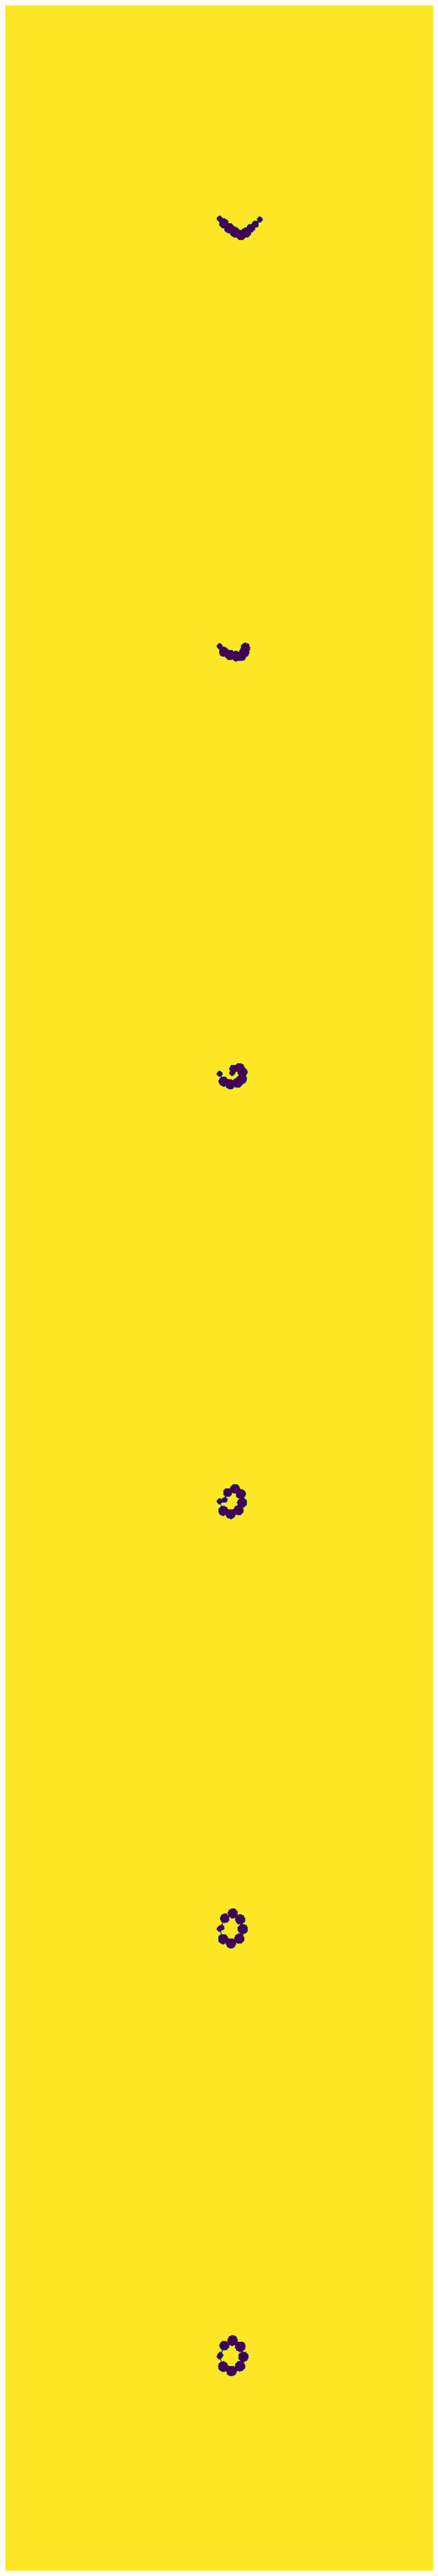

In [41]:
# Interpolating between strokes
def interpolate(idx0, idx1):
    t = trajectories
    t0 = t[idx0].unsqueeze(0).to(device)
    t1 = t[idx1].unsqueeze(0).to(device)
    enc0, _ = model.encode(t0)
    enc1, _ = model.encode(t1)
    
    num_images = 6
    data = []
    for i in range(num_images):
        t = i / (num_images - 1)
        enc = enc0*(1-t) + enc1*t
        trajectory = model.decode(enc)
        trajectory = tv.visualize_trajectory(trajectory.cpu().detach().squeeze(0))
        data.append([trajectory])
    no_gap_plot(data)

interpolate(11, 202)

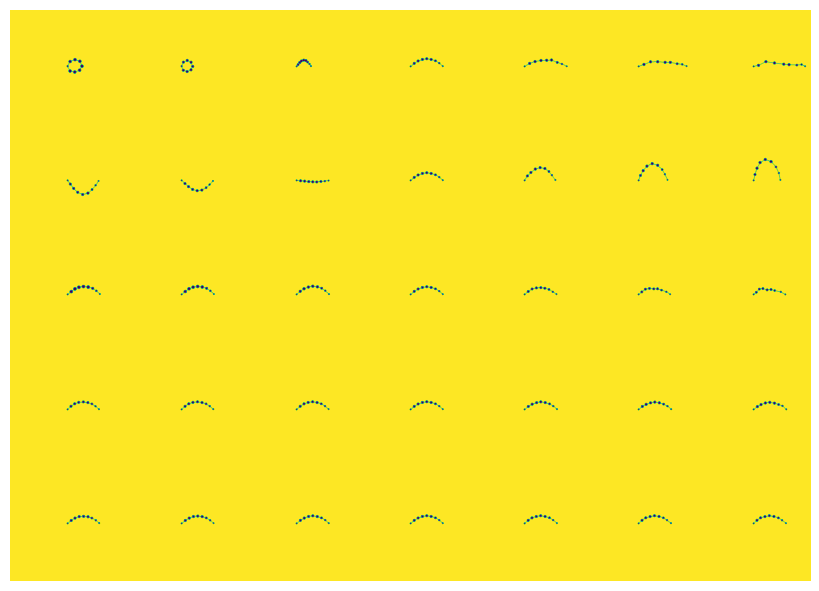

In [43]:
# Varying different latent variables at a time
def vary_one_at_a_time(idx):
    t = trajectories[idx].unsqueeze(0).to(device)
    enc, _ = model.encode(t)
    data = []
    for i in range(5):
        data_row = []
        for j in range(-3, 4):
            shift = torch.zeros(5)
            shift[i] += j
            shift = shift.to(device)
            shifted = enc + shift
            trajectory = model.decode(shifted)
            trajectory = tv.visualize_trajectory(trajectory.cpu().detach().squeeze(0))
            data_row.append(trajectory)
        data.append(data_row)
    no_gap_plot(data)
vary_one_at_a_time(1)

### Training the trajectory-to-stroke model

In [7]:
# generate trajectories and simulate their strokes
_, generated_trajectories = model.sample_latent(300)
strokes = []
for t in generated_trajectories:
    strokes.append(tv.render_trajectory(t.cpu().detach()))
strokes = torch.stack(strokes, dim=0)

train_test_split = int(0.8 * len(generated_trajectories))
train = strokes[:train_test_split], generated_trajectories[:train_test_split]
test = strokes[train_test_split:], generated_trajectories[train_test_split:]

train_dataset = StrokeTrajDataset(*train)
val_dataset = StrokeTrajDataset(*test)

torch.save(train_dataset, "traj_to_stroke_train.pt")
torch.save(val_dataset, "traj_to_stroke_val.pt")

In [14]:
wandb.init(project="diverse-strokes-traj-to-stroke", mode="online")

train_dataset = torch.load("traj_to_stroke_train.pt")
val_dataset = torch.load("traj_to_stroke_val.pt")
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

traj_to_stroke = TrajToStroke()
traj_to_stroke.to(device)
optimizer = optim.Adam(traj_to_stroke.parameters())

num_epochs = 1000
epochs_per_save = 50
wandb.config = {
    "num_epochs": num_epochs
}

def validation(model, dataloader, need_outputs):
    model.eval()
    total_loss = 0
    trajectories = []
    simulated_strokes = []
    model_predictions = []
    
    for (stroke, trajectory) in dataloader:
        batch_size = len(stroke)
        stroke = stroke.to(device)
        trajectory = trajectory.to(device)
        stroke_hat = traj_to_stroke(trajectory)
        loss = traj_to_stroke.loss(stroke, stroke_hat)
        total_loss += loss * batch_size
        
        if need_outputs:
            for i in range(batch_size):
                traj = tv.visualize_trajectory(trajectory[i].cpu().detach()).float()
                stroke_ = stroke[i].squeeze(0).cpu().detach()
                stroke_hat_ = stroke_hat[i].squeeze(0).cpu().detach()

                trajectories.append(traj)
                simulated_strokes.append(stroke_)
                model_predictions.append(stroke_hat_)

    avg_loss = total_loss / len(dataloader.dataset)
    model.train()
    return avg_loss, trajectories, simulated_strokes, model_predictions

for epoch in range(num_epochs):
    total_loss = 0
    for (i, (stroke, trajectory)) in enumerate(train_dataloader):
        batch_size = len(stroke)
        stroke = stroke.to(device)
        trajectory = trajectory.to(device)
        stroke_hat = traj_to_stroke(trajectory)
        loss = traj_to_stroke.loss(stroke, stroke_hat)
        total_loss += loss * batch_size
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i == 0 and epoch%epochs_per_save == epochs_per_save-1:
            output_dir = f"training_outputs_traj_to_stroke/epoch{epoch}/train"
            os.makedirs(output_dir, exist_ok=True)
            for i in range(batch_size):
                traj = tv.visualize_trajectory(trajectory[i].cpu().detach()).float()
                stroke_ = stroke[i].squeeze(0).cpu().detach()
                stroke_hat_ = stroke_hat[i].squeeze(0).cpu().detach()

                images = [
                    wandb.Image(traj, caption='trajectory'),
                    wandb.Image(stroke_, caption='simulated stroke'),
                    wandb.Image(stroke_hat_, caption='model prediction')
                ]
                wandb.log({"training outputs": images})
                plt.imsave(f"{output_dir}/{i}-trajectory.png", traj)
                plt.imsave(f"{output_dir}/{i}-simulated_stroke.png", stroke_)
                plt.imsave(f"{output_dir}/{i}-model_prediction.png", stroke_hat_)
    
    train_loss = total_loss / len(train_dataset)
    val_loss, val_trajectories, val_simulated_strokes, val_model_predictions = validation(traj_to_stroke, val_dataloader, epoch%epochs_per_save == epochs_per_save-1)
    wandb.log({
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss
    })
    print(f"Epoch {epoch}: Train loss={train_loss.item()}, Validation loss={val_loss.item()}")
    
    if epoch%epochs_per_save == epochs_per_save-1:
        output_dir = f"training_outputs_traj_to_stroke/epoch{epoch}/val"
        os.makedirs(output_dir, exist_ok=True)
        for i in range(len(val_trajectories)):
            traj = val_trajectories[i]
            stroke_ = val_simulated_strokes[i].squeeze(0).cpu().detach()
            stroke_hat_ = val_model_predictions[i].squeeze(0).cpu().detach()
            
            images = [
                    wandb.Image(traj, caption='trajectory'),
                    wandb.Image(stroke_, caption='simulated stroke'),
                    wandb.Image(stroke_hat_, caption='model prediction')
                ]
            wandb.log({"validation outputs": images})
            plt.imsave(f"{output_dir}/{i}-trajectory.png", traj)
            plt.imsave(f"{output_dir}/{i}-simulated_stroke.png", stroke_)
            plt.imsave(f"{output_dir}/{i}-model_prediction.png", stroke_hat_)

torch.save(traj_to_stroke.state_dict(), "traj_to_stroke.pt")

In [7]:
%%capture
traj_to_stroke = TrajToStroke()
traj_to_stroke.load_state_dict(torch.load("traj_to_stroke.pt"))
traj_to_stroke.to(device)

In [24]:
combined_model = CombinedModel(model, traj_to_stroke, device)

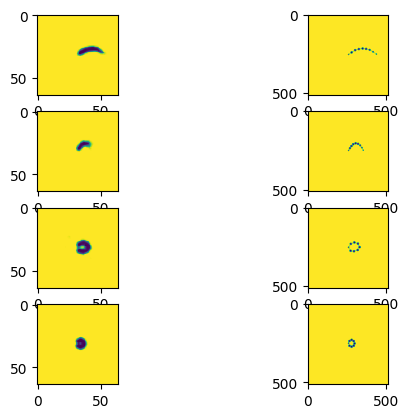

In [33]:
_, s, t = combined_model.sample_latent(4)
_, axs = plt.subplots(4, 2)
for i in range(4):
    axs[i][0].imshow(s[i].squeeze(0).cpu().detach())
    axs[i][1].imshow(tv.visualize_trajectory(t[i].cpu().detach()))

In [14]:
from self_improvement import evaluate_consistency
print(evaluate_consistency(combined_model))

tensor(0.0001)
